# Resume Classifier with Naive Bayes Classifier
<p>According to <b><a href="https://careers.workopolis.com/">Workopolis</a></b>, Employers receive averagely between 75 and 250 applications per job posting. This can make it difficult and stressful to identify qualified candidates. In order to avoid having to read through the entire pile of resumes, most employers use applicant tracking systems (ATS).<br></p>
<p>Applicant tracking system software ranks each applicant based on how well their resume scores based on the job description. In this project, I work with a Dataset to build a model that screens resumes and can be practically used in companies.</p>

In [8]:
#Install Packages if not already installed
#!pip install nltk
#!pip install gensim
#!pip install wordcloud


#Import libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.metrics import classification_report, confusion_matrix

## Import Data

CSV Structure:


|resume_id|class|resume_text|
| :-| :- | :-|
|resume_1|not_flagged|Customer Service Supervisor/Tier -...|
| ... | ... | ... |

**resume_id** -Candidate CV ID <br>
**class** - Target Feature( indicates if the Candidate was invited for an interview or not).<br>
**resume_text** -Resume text content scrapped file each file


In [10]:
# load the data
resume_df=pd.read_csv('../data/resume.csv',encoding='latin-1')
resume_df.head()

,resume_id,class,resume_text
0,resume_1,not_flagged,\rCustomer Service Supervisor/Tier - Isabella ...
1,resume_2,not_flagged,\rEngineer / Scientist - IBM Microelectronics ...
2,resume_3,not_flagged,\rLTS Software Engineer Computational Lithogra...
3,resume_4,not_flagged,TUTOR\rWilliston VT - Email me on Indeed: ind...
4,resume_5,flagged,\rIndependent Consultant - Self-employed\rBurl...


Now we drop the " **resume_id** " because its not important for our model build.

In [11]:
# data containing resume
resume_df= resume_df[['resume_text','class']]
resume_df.head()

,resume_text,class
0,\rCustomer Service Supervisor/Tier - Isabella ...,not_flagged
1,\rEngineer / Scientist - IBM Microelectronics ...,not_flagged
2,\rLTS Software Engineer Computational Lithogra...,not_flagged
3,TUTOR\rWilliston VT - Email me on Indeed: ind...,not_flagged
4,\rIndependent Consultant - Self-employed\rBurl...,flagged


## Exploratory Data Analysis

Before making assumptions, lets look at data and see if we can identify errors and understand patterns within the data.

In [12]:
# obtain dataframe information
resume_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   resume_text  125 non-null    object
 1   class        125 non-null    object
dtypes: object(2)
memory usage: 2.1+ KB


In [13]:
# Find Null/Missing Values
resume_df.isnull().sum()

resume_text    0
class          0
dtype: int64

<AxesSubplot:>

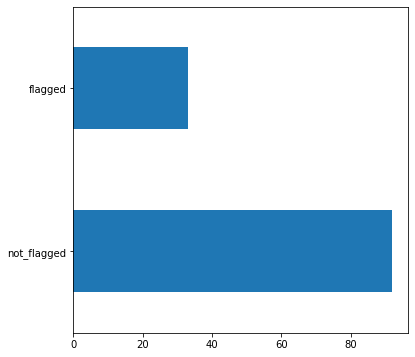

In [15]:
#View distribution
resume_df['class'].value_counts().plot(kind='barh', figsize=(6, 6))

#### Encode the Class Values 
**flagged:** 1 <br>
**not_flagged:** 0

In [16]:
resume_df['class']=resume_df['class'].apply(lambda x:1 if x=='flagged' else 0)
resume_df.head()

,resume_text,class
0,\rCustomer Service Supervisor/Tier - Isabella ...,0
1,\rEngineer / Scientist - IBM Microelectronics ...,0
2,\rLTS Software Engineer Computational Lithogra...,0
3,TUTOR\rWilliston VT - Email me on Indeed: ind...,0
4,\rIndependent Consultant - Self-employed\rBurl...,1
